# Summary
There are two parts to how a movement between point A and point B might vary. The first is variance in the actual movement path taken to get from point A to point B, and the second is the speed of the movement. Here, I'll analyze the movement path variance, `var_p`, across all __Hit__ trials that successfully have movement from the first threshold to the second threshold and back to the first threshold (this back threshold will effectively be a third threshold) from 1 day (and ignore variance in speed for now). I will define a `movement` as the recorded lever movement between a defined first to second threshold and back for the third threshold. 

__Note on possible movements:__
![](./images/2_var_p_cases.jpeg)

This image lists some of the possible cases that could occur with movement. For our analysis, all of these movements will count. The first, second, and third thresholds are marked with stars, and the beginning of the movement window and ending of the movement window are marked with vertical lines.

The folder defined by `lever_data_folder` needs contain the processed `lever_data` as processed_lever_data_trial#.bin binary files. First, the extracted movements will have MVT0 subtracted off and be temporally aligned to be comparable. They will be saved to a movement_trial#.npy file also in the folder defined by `output_folder`. From this point forward, I'm using `np.save()` to save all analysis as 2D arrays since I'm assuming I don't need to reaccess or further process the entire giant data with C++ anymore.

Then the movements will be scaled across % completion of their entire movement path. This percent completion movement will be saved again in `output_folder` as a movement_percent_scaled_trial#.npy file.

I will then plot the variance of this path, `var_p`, over the % movement completion between the first to second to third threshold.

I also calculate the average movement path, `mean_p`, for __Hit__ trials that had movement from the first to second to third threshold for this 1 day.

### imports:

In [3]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
import scipy.signal as signal

# interpolation because ARDUINO data is spaced unevenly
import scipy.interpolate as interpolate

import pickle # save data
import glob # find files in a directory
import re # regex for string parsing

### set `folder_name` and `day`

In [71]:
folder_name = './Data/AnB1/'
day = 1
lever_data_folder = "./Data/AnB1/LeverData_ANB1_d1/"
lever_data_matfile = "./Data/AnB1/LeverData_ANB1_d1.mat"
output_folder = "./Data/AnB1/analysis2_ANB1_d1/"
!mkdir {output_folder}

### sort through relevant .mat files found in folder by day ("_d#")

In [5]:
# for all ToneDisc .mat files in this folder starting with "ToneDisc_" in their name
mat_file = glob.glob(folder_name+'ToneDisc_*d'+str(day)+'.mat')[0]

### extract one day's data from corresponding .mat file

In [6]:
mat_dict = io.loadmat(mat_file)

data = mat_dict['data'][0][0]
params = data[0][0][0]
response = data[1][0][0]

### find all movements from trials that meet both thresholds, and store the trial index and arduion indices for these movements in `movements` so we can find them again later

list `movements`: each element is a list about the movement, 3 subelements per movement `trial_i` |  `first_threshold_lever_i` | `second_threshold_lever_i`

In [19]:
# get `respMTX` (trials) from response
respMTX = response[2]

MVT0 = respMTX[0, 4] * -1
print("MVT0 for all trials should be the same: ", MVT0)
num_trials = respMTX.shape[0]
print("num trials: ", num_trials)
mvt_threshold = params[7][0][0][0][0][0] /0.0049 *5 /1023 # uhhh VBP's conversion rate is not exact
print("mvt threshold: ", mvt_threshold, "+ MVT0 = ", MVT0 + mvt_threshold)
nomvt_threshold = params[7][0][0][1][0][0] /0.0049 *5 /1023
print("nomvt threshold: ", nomvt_threshold, "+ MVT0 = ", MVT0 + nomvt_threshold)

MVT0 for all trials should be the same:  2.669568999999999
num trials:  183
mvt threshold:  0.17954395834580164 + MVT0 =  2.849112958345801
nomvt threshold:  0.11969597223053444 + MVT0 =  2.7892649722305336


In [47]:
# Parameters for extracting movements:
first_threshold = MVT0 + nomvt_threshold
second_threshold = MVT0 + mvt_threshold
third_threshold = MVT0 + nomvt_threshold

rewarded_trials = 0
movements = []
rejected_reward_movements = []
for trial_i in range(0, num_trials):

    # Read the binary file created by the C++ program which is saved as double
    trial_frequencies = np.fromfile(lever_data_folder+"trial_frequencies.bin", dtype=np.double)
    lever_data = np.fromfile(lever_data_folder+"processed_trial"+str(trial_i)+".bin", dtype=np.double)
    num_samples = lever_data.shape[0]
    fs = trial_frequencies[trial_i]
    trial_start_time = respMTX[trial_i, 0]
    lever_ts = np.linspace(trial_start_time, trial_start_time + ((1/fs)*num_samples), num=num_samples)

    # only trials where there was a tone
    if ~np.isnan(respMTX[trial_i, 1]):
        # get the row in lever_data for tone_t
        tone_t = respMTX[trial_i, 1]
        for lever_i, lever_t in enumerate(lever_ts):
            if tone_t <= lever_t:
                tone_lever_i = lever_i
                break
        
        if respMTX[trial_i, 6] == 1:
            rewarded_trials += 1
            # get the row in lever_data for lever_pressed_t
            lever_pressed_t = respMTX[trial_i, 3]
            for lever_i, lever_t in enumerate(lever_ts):
                if lever_pressed_t <= lever_t:
                    lever_pressed_lever_i = lever_i
                    break
            print("rewarded @ ", lever_data[lever_pressed_lever_i], "V")

            # first threshold
            first_threshold_lever_i = 0
            # if lever was pressed
            if ~np.isnan(respMTX[trial_i, 3]):
                for lever_i, lever_value in enumerate(lever_data[\
                    tone_lever_i:\
                    ]):
                    if lever_value >= first_threshold:
                        first_threshold_lever_i = lever_i + tone_lever_i
                        break

            # second threshold
            second_threshold_lever_i = 0
            # if lever was pressed
            if ~np.isnan(respMTX[trial_i, 3]):
                for lever_i, lever_value in enumerate(lever_data[\
                    first_threshold_lever_i:\
                    ]):
                    if lever_value >= second_threshold:
                        second_threshold_lever_i = lever_i + first_threshold_lever_i
                        break
            
            # third threshold
            third_threshold_lever_i = 0
            # if lever was pressed
            if ~np.isnan(respMTX[trial_i, 3]):
                for lever_i, lever_value in enumerate(lever_data[\
                    second_threshold_lever_i:\
                    ]):
                    if lever_value <= third_threshold:
                        third_threshold_lever_i = lever_i + second_threshold_lever_i
                        break

            # if both first threshold and second threshold are met, add to movements
            if (first_threshold_lever_i != 0) and (second_threshold_lever_i !=0) and (third_threshold_lever_i !=0):
                movement_lever_ts = lever_ts[first_threshold_lever_i:third_threshold_lever_i]
                movement_lever_data = lever_data[first_threshold_lever_i:third_threshold_lever_i]
                movements.append([trial_i, movement_lever_ts, movement_lever_data])
            else:
                not_met = ""
                if (first_threshold_lever_i == 0):
                    not_met = not_met + "1st "
                if (second_threshold_lever_i == 0):
                    not_met = not_met + "2nd "
                if (third_threshold_lever_i == 0):
                    not_met = not_met + "3rd "
                movement_lever_ts = lever_ts[tone_lever_i:]
                movement_lever_data = lever_data[tone_lever_i:]
                rejected_reward_movements.append([trial_i, movement_lever_ts, movement_lever_data])
                print("ERROR: rewarded, but not all thresholds for trial ", trial_i, ": ", not_met)

print("number of rewarded trials: ", rewarded_trials)
print("number of extracted_movements ", len(movements))

rewarded @  3.0500575560109566 V
rewarded @  2.848718974698425 V
rewarded @  2.8888499879637983 V
rewarded @  2.8540945204554355 V
rewarded @  2.922151526444701 V
rewarded @  2.8850231665508494 V
rewarded @  2.9029469970163437 V
rewarded @  2.897001883061401 V
rewarded @  2.92230611402721 V
rewarded @  2.8662336335807437 V
rewarded @  2.9444749651683058 V
rewarded @  2.71006258534309 V
rewarded @  2.814881009743594 V
rewarded @  2.910062863496086 V
rewarded @  2.8899683042170814 V
rewarded @  2.9073704725158267 V
rewarded @  2.817387242721768 V
rewarded @  2.798647046888558 V
rewarded @  2.9981915316940775 V
rewarded @  2.9160441605286462 V
rewarded @  2.867777303935577 V
rewarded @  2.9672039494280953 V
rewarded @  2.9078065874019963 V
rewarded @  2.918896659556293 V
rewarded @  2.8946145381518757 V
rewarded @  2.888978552686093 V
rewarded @  2.8167847049021253 V
rewarded @  2.951834706706603 V
rewarded @  2.839926051693067 V
rewarded @  2.890871482798851 V
rewarded @  2.8847343757047

check by plotting MVT0 subtracted and temporally aligned movements:

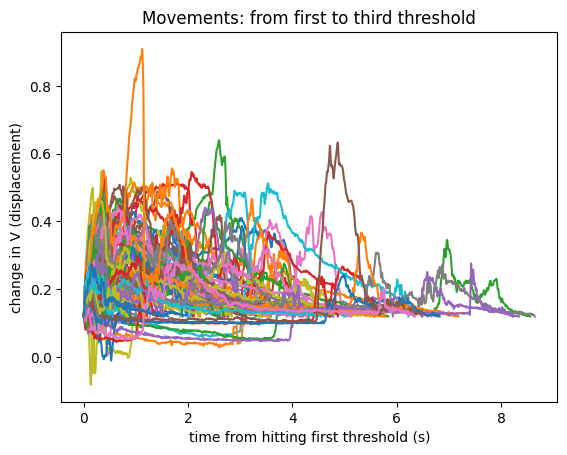

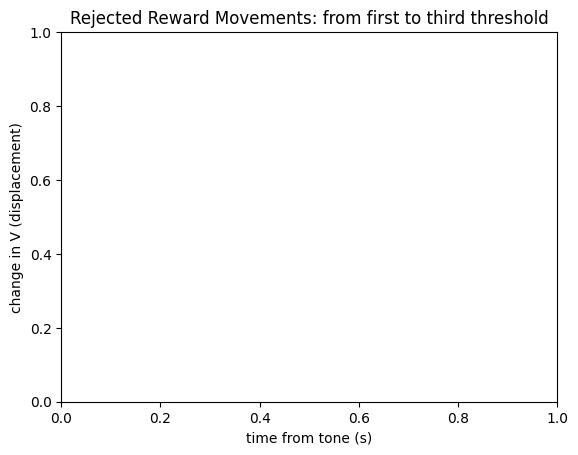

In [48]:
for movement in movements:
    # also check by plotting all of the movements
    plt.plot(\
        movement[1] - movement[1][0],\
        movement[2] - MVT0\
        )
plt.title("Movements: from first to third threshold")
plt.xlabel("time from hitting first threshold (s)")
plt.ylabel("change in V (displacement)")
#plt.xlim([0, 1])
plt.show()

for movement in rejected_reward_movements:
    # also check by plotting all of the movements
    plt.plot(\
        movement[1] - movement[1][0],\
        movement[2] - MVT0\
        )
plt.title("Rejected Reward Movements: from first to third threshold")
plt.xlabel("time from tone (s)")
plt.ylabel("change in V (displacement)")
plt.show()

### Save the MVT0 subtracted and temporally aligned movements from `movements` into separate "movement_trial#" .npy files

In [72]:
for movement in movements:
    trial_i = movement[0]
    movement_data = np.array([movement[1] - movement[1][0], \
                              movement[2] - MVT0])
    print("movement_data shape: ", movement_data.shape)
    np.save(output_folder+"movement_trial"+str(trial_i), movement_data)

movement_data shape:  (2, 16992)


FileNotFoundError: [Errno 2] No such file or directory: './Data/AnB1/analysis2_ANB1_d1/movement_trial0.npy'

### Plot the movement paths across % movement completed as the x-axis

Text(0.5, 1.0, 'Movement paths from first to third threshold (1 day) up close')

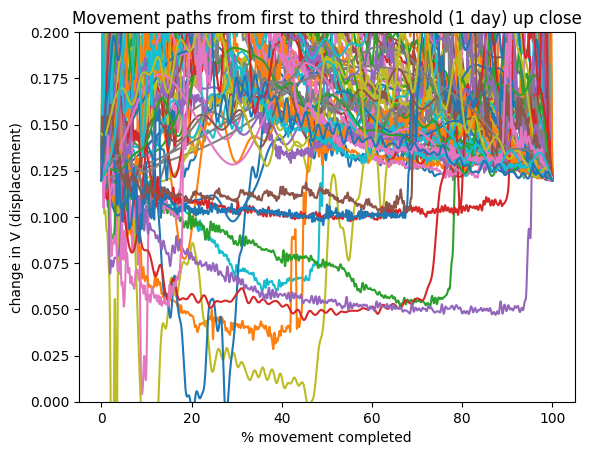

In [56]:
for movement in movements:
    # also check by plotting all of the movements
    plt.plot(\
        (movement[1] - movement[1][0]) *100 /(movement[1][-1] - movement[1][0]),\
        movement[2] - MVT0\
        )
plt.xlabel("% movement completed")
plt.ylabel("change in V (displacement)")
plt.title("Movement paths from first to third threshold (1 day)")

for movement in movements:
    # also check by plotting all of the movements
    plt.plot(\
        (movement[1] - movement[1][0]) *100 /(movement[1][-1] - movement[1][0]),\
        movement[2]\
        )
plt.xlabel("% movement completed")
plt.ylabel("change in V (displacement)")
plt.ylim([0, 0.2])
plt.title("Movement paths from first to third threshold (1 day) up close")

### Make functions scaled from 0-100% of movement path completion to analyze movement path variability
And save all of them together in "movements_percent_scaled.npy" file.

These scaled 0-100% movement path functions are made by linearly interpolating the original data at rates above sampling rate to make an approximate continuous function throughout the path. Right now, the `num_samples` = 10*10000 for a minimum sampling rate of 10kHz since __the movements all take less than 10s__.

In [70]:
num_samples = 10*10000
movements_percent_scaled = np.array([]).resize((num_samples, len(movements)))
for movement in movements:
    trial_i = movement[0]
    # Read the binary file created by the C++ program which is saved as double
    trial_frequencies = np.fromfile(lever_data_folder+"trial_frequencies.bin", dtype=np.double)
    movement_data = np.load(lever_data_folder+"movement_trial"+str(trial_i)+".npy")
    percent_completion_x = np.linspace(0, 100, movement_data[1,:].shape[0])

    movement_data_fcn = interpolate.interp1d(percent_completion_x, movement_data[1, :], kind='linear')
    new_x = percent_completion_x = np.linspace(0, 100, num_samples)
    new_y = movement_data_fcn(new_x)
    movements_percent_scaled = np.array([new_x, new_y])

    # use np.save()
    np.save(lever_data_folder+"movement_percent_scaled_trial"+str(trial_i), movement_percent_scaled)


### calculate the movement path variance, `var_p`, across each `interpolated_movement_dataArduino`

In [31]:
var_p=np.var(, axis=0)

plot `var_p` across % movement completed

Text(0.5, 1.0, 'Variance of movement paths from first to second threshold for this day')

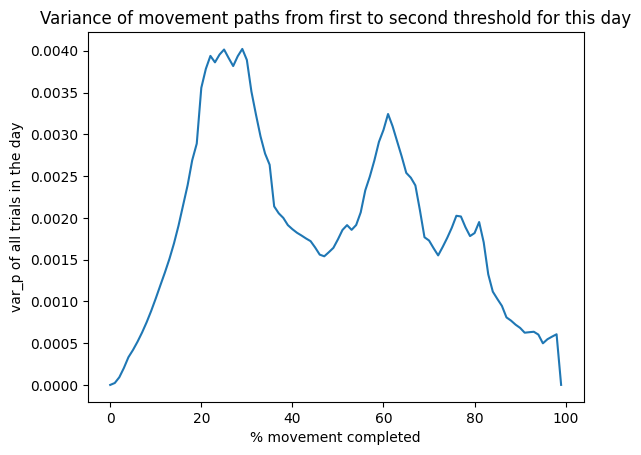

In [32]:
plt.plot(range(0,100), var_p)
plt.xlabel("% movement completed")
plt.ylabel("var_p of all trials in the day")
plt.title("Variance of movement paths from first to second threshold for this day")

### Also calculate the average movement path, `mean_ps`, across each `interpolated_movement_dataArduino`

In [33]:
mean_p=np.mean(interpolated_movements_dataArduino, axis=0)

plot `mean_p` across % movement completed

Text(0.5, 1.0, 'Mean movement path from first to second threshold for this day')

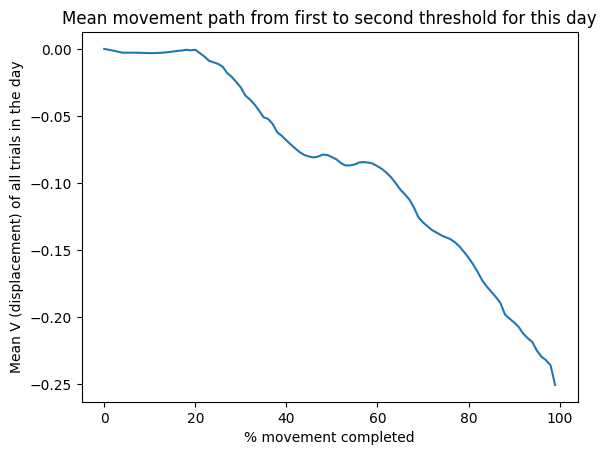

In [34]:
plt.plot(range(0,100), mean_p)
plt.xlabel("% movement completed")
plt.ylabel("Mean V (displacement) of all trials in the day")
plt.title("Mean movement path from first to second threshold for this day")

### save `movements_dataArduino`, `interpolated_movements_dataArduino`, and `movements_var_ps` in the same folder

In [35]:
file = open(mat_file_string+'_interpolated_times_dataArduino.pickle', 'wb')
pickle.dump(interpolated_times_dataArduino, file)
file.close()

file = open(mat_file_string+'_interpolated_movements_dataArduino.pickle', 'wb')
pickle.dump(interpolated_movements_dataArduino, file)
file.close()

file = open(mat_file_string+'_movements_dataArduino.pickle', 'wb')
pickle.dump(movements_dataArduino, file)
file.close()

file = open(mat_file_string+'_var_p.pickle', 'wb')
pickle.dump(var_p, file)
file.close()

file = open(mat_file_string+'_mean_p.pickle', 'wb')
pickle.dump(mean_p, file)
file.close()